# Sensitivity of Fold-Change to $F$

© 2019 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 

In [1239]:
import sys
sys.path.insert(0, '../../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mut.thermo
import mut.bayes
import mut.viz
import tqdm
pboc = mut.viz.color_selector('pboc')

constants = mut.thermo.load_constants()
mut.viz.plotting_style()

In my analysis, I have found that at the extremes of fold-change the $\Delta F$ is poorly resolved and has aninteresting trend towards $\Delta F = 0$. I think this has something to do with the fact that when you approach the asymptotes of fold-change, the magnitude of the empirical $F$ gets very large. As a reminder, the empirical $F$ can be calculated from the fold-change data as

$$
F_\text{empirical} = \log \left( {1 \over \text{fold-change}} -1\right)
$$

# Generating a fake data set
We can generate a dataset in which fold-change measurements are normally distributed about a value prescribed by the theory. 

In [2006]:
sigma = 0.05
n_reps = 5
true_bohr = np.linspace(-10, 10, 100)
dataset_fc = []
fc_mu = (1 + np.exp(-true_bohr))**-1
fc_mut = (1 + np.exp(-true_bohr-2))**-1
for i, b in enumerate(true_bohr):
    mu = fc_mut[i]
    dataset = np.random.normal(mu, sigma, n_reps)
    df = pd.DataFrame(dataset.T, columns=['fold_change'])
    df['replicate'] = np.arange(n_reps)
    df['true_bohr'] = b
    dataset_fc.append(df)
dataset = pd.concat(dataset_fc)

In [2007]:
# Load the stan model
# model = mut.bayes.StanModel('../stan/empirical_F.stan')#, force_compile=True)
stan_dfs = []
for g, d in dataset.groupby('true_bohr'):
    data_dict = {'N':len(d), 'ref_bohr':g, 'foldchange':d['fold_change']}
    fit, samples = model.sample(data_dict, iter=5000, control=dict(adapt_delta=0.99))
    corr_bohr = -np.log((1/np.abs(samples['fc_mu'].values - samples['fc_sigma']))-1) -\
                    np.log(np.abs((1/(samples['fc_mu'].values + samples['fc_sigma'])) - 1))
    samples['corr'] = corr_bohr
    stats = mut.stats.compute_statistics(samples, varnames=['fc_mu', 'fc_sigma',
                                                           'empirical_bohr',
                                                            'delta_bohr', 'corr'],
                                        logprob_name='lp__')
    stats['true_bohr'] = g
    stats['fc_mu_std'] = np.std(samples['fc_mu'])
    stan_dfs.append(stats)
stats = pd.concat(stan_dfs)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


(array([2.000e+00, 2.000e+00, 2.400e+01, 9.300e+01, 6.710e+02, 3.431e+03,
        5.169e+03, 5.960e+02, 8.000e+00, 4.000e+00]),
 array([-1.58662704, -0.37577106,  0.83508491,  2.04594089,  3.25679686,
         4.46765284,  5.67850881,  6.88936478,  8.10022076,  9.31107673,
        10.52193271]),
 <a list of 10 Patch objects>)

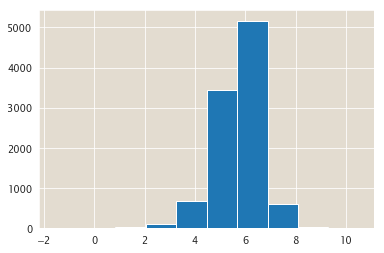

In [2008]:
plt.hist(corr_bohr)

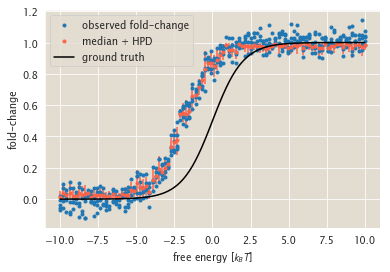

In [2009]:
_fc_mu = stats[stats['parameter']=='fc_mu']
plt.plot(dataset['true_bohr'], dataset['fold_change'], '.', label='observed fold-change')
plt.plot(_fc_mu['true_bohr'], _fc_mu['mean'], '.', color='tomato', label='median + HPD' )
plt.vlines(_fc_mu['true_bohr'], _fc_mu['hpd_min'], _fc_mu['hpd_max'], color='tomato', label='__nolegend__')
plt.plot(true_bohr, (1 + np.exp(-true_bohr))**-1, 'k-', label='ground truth')
plt.xlabel('free energy [$k_BT$]')
plt.ylabel('fold-change')
plt.legend()

(-10, 10)

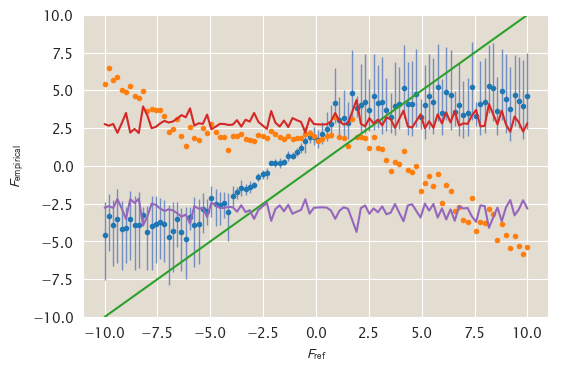

In [2048]:
plt.figure(dpi=100)
dbohr = stats[stats['parameter']=='delta_bohr']
bohr = stats[stats['parameter']=='empirical_bohr']
_sigma = stats[stats['parameter']=='fc_sigma']['median'].values
_fc_mu = stats[stats['parameter']=='fc_mu']['median'].values
corr_bohr = stats[stats['parameter']=='corr']
sig = sigma * np.ones(len(true_bohr))
err1= -np.log((1/(1 - _sigma)) - 1)
err2 = -np.log((1/_sigma) - 1)
corr = -(bohr['median'] - true_bohr)* np.exp(-bohr['median'].values) / ((_fc_mu**2 - _fc_mu) * (1 + np.exp(-bohr['median'].values))**2)
plt.plot(true_bohr, bohr['median'],'.') 
plt.plot(true_bohr, corr,'.') 
plt.vlines(true_bohr, bohr['hpd_min'], bohr['hpd_max'], color=pboc['blue'], lw=1)
plt.plot(true_bohr, true_bohr, '-')
plt.plot(true_bohr, np.log((1/_sigma) -1))
plt.plot(true_bohr, -np.log((1/(_sigma)) -1))
plt.xlabel('$F_\mathrm{ref}$')
plt.ylabel('$F_\mathrm{empirical}$')
plt.ylim([-10, 10])

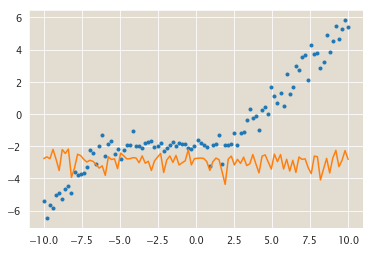

In [2337]:

plt.plot(true_bohr, true_bohr - bohr['median'], '.')

# plt.plot(true_bohr,dbohr['median'] - dbohr['median']/ np.log((1/_sigma) - 1), -10, 10)
a =  true_bohr - np.log(_sigma**-1 -1)
b =  true_bohr + np.log(_sigma**-1 -1)

plt.plot(true_bohr,

# plt.plot(true_bohr, -np.log((1/_sigma)- 1), -10, 10)


# plt.plot(true_bohr, true_bohr, color='tomato')


# plt.plot(true_bohr, true_bohr - bohr['median'] + corr)
# plt.plot(true_bohr, corr)
# plt.plot(_fc_mu, dbohr['median']-(_fc_mu**2 - _fc_mu), '.')
# plt.xlabel('ref bohr')
# plt.ylabel('∆F')

In [2273]:
(true_bohr) / np.log((1/_sigma) - 1)

array([-3.61080533, -3.68112252, -3.45065624, -4.27842391, -3.26239867,
       -2.56239985, -3.98410958, -3.50274558, -3.8486271 , -2.07806749,
       -2.38377842, -3.11190708, -2.93104951, -2.61903515, -2.40328324,
       -2.42464056, -2.30046031, -2.09174138, -1.89328768, -1.91253701,
       -1.56324631, -2.16061628, -1.96575765, -1.9215498 , -1.51739686,
       -2.03738974, -1.82735278, -1.63073149, -1.56255902, -1.52658407,
       -1.4416533 , -1.23322079, -1.35859074, -1.08997804, -1.06598354,
       -0.83457074, -0.93455174, -0.94307302, -0.94687642, -0.58369295,
       -0.67171617, -0.65804172, -0.50412353, -0.50994659, -0.3506198 ,
       -0.30004802, -0.24269569, -0.22829231, -0.09585707, -0.03642698,
        0.03670822,  0.11057005,  0.18306488,  0.23959261,  0.25934598,
        0.37461965,  0.47962744,  0.5340005 ,  0.47794588,  0.43896517,
        0.7579225 ,  0.88756049,  0.7977697 ,  0.96829944,  0.95463652,
        1.16735689,  1.04053992,  1.14237041,  1.48293725,  1.26

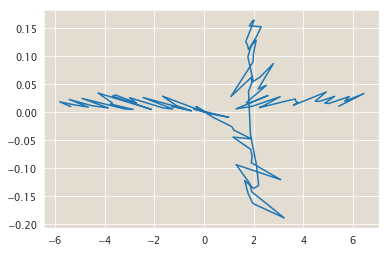

In [2193]:
dfemp =  np.exp(-bohr['median'].values) / (1 + np.exp(-bohr['median'].values))**2
dfemp =  np.exp(-bohr['median'].values) / (1 + np.exp(-bohr['median'].values))**2
# df = np.exp(-true_bohr) / (1 + np.exp(-true_bohr))**2
# plt.plot(_fc_mu, dfemp)

# plt.plot(true_bohr, dbohr['median'] - (dfemp - df) * dbohr['median'], '.')
# plt.yscale('log')

In [2198]:
np.log((1/_sigma)-1)**2

array([ 7.66993793,  7.08455434,  7.7334526 ,  4.82089732,  7.93849788,
       12.30880309,  4.86525453,  6.00828153,  4.74541424, 15.50173656,
       11.20603635,  6.24680314,  6.68045172,  7.92670467,  8.90505065,
        8.26291075,  8.65465435,  9.85236173, 11.29737363, 10.37933629,
       14.53378757,  7.10107394,  7.98720889,  7.76207904, 11.52581387,
        5.90165126,  6.74963873,  7.76944011,  7.72669308,  7.35962812,
        7.46684548,  9.18441257,  6.77155483,  9.35237676,  8.62883168,
       12.31967638,  8.51628987,  7.16999716,  6.02003038, 13.2068518 ,
        8.16328959,  6.80958427,  9.03312843,  6.63081525, 10.04250593,
        9.17979748,  8.48792541,  4.8942601 ,  9.99364206,  7.6892364 ,
        7.57186631,  7.51098811,  7.61131233,  8.70921156, 12.28727565,
        8.79698558,  7.49563212,  8.05061017, 12.9083285 , 19.11510495,
        7.83282823,  6.85155833, 10.01969624,  7.93300587,  9.41563296,
        7.19524677, 10.26218872,  9.57749217,  6.35166393,  9.66

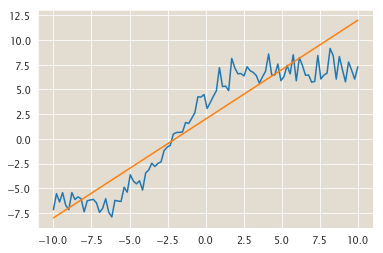

In [2152]:
# plt.plot(true_bohr, bohr['median'], '.')
# plt.plot(true_bohr, true_bohr)
plt.plot(true_bohr, bohr['median'] - np.log((1/(_fc_mu + -1 * np.sign(true_bohr) *  _sigma) - 1)))
plt.plot(true_bohr, true_bohr + 2)


In [2153]:
bohr['median'] / true_bohr

2    0.456531
2    0.341030
2    0.408362
2    0.375925
2    0.452664
2    0.457450
2    0.399867
2    0.457500
2    0.464674
2    0.397047
2    0.547149
2    0.513970
2    0.511755
2    0.500790
2    0.539085
2    0.679144
2    0.640663
2    0.531428
2    0.690979
2    0.790080
2    0.566703
2    0.679259
2    0.692660
2    0.530096
2    0.576325
2    0.434679
2    0.525599
2    0.576212
2    0.558293
2    0.738660
       ...   
2    1.240901
2    0.940113
2    0.909230
2    1.002281
2    0.661036
2    0.784002
2    0.869589
2    0.763340
2    0.911652
2    0.588038
2    0.796167
2    0.740768
2    0.541812
2    0.597526
2    0.487814
2    0.485150
2    0.711708
2    0.435404
2    0.524311
2    0.527150
2    0.649992
2    0.617178
2    0.426695
2    0.560943
2    0.494529
2    0.408221
2    0.502980
2    0.448493
2    0.405518
2    0.462395
Name: median, Length: 100, dtype: float64

array([-1.05263158, -1.05263158, -1.05263158, -1.05263158, -1.05263158,
       -1.05263158, -1.05263158, -1.05263158, -1.05263158, -1.05263158,
       -1.05263158, -1.05263158, -1.05263158, -1.05263158, -1.05263158,
       -1.05263158, -1.05263158, -1.05263158, -1.05263158, -1.05263158,
       -1.05263158, -1.05263158, -1.05263158, -1.05263158, -1.05263158,
       -1.05263158, -1.05263158, -1.05263158, -1.05263158, -1.05263158,
       -1.05263158, -1.05263158, -1.05263158, -1.05263158, -1.05263158,
       -1.05263158, -1.05263158, -1.05263158, -1.05263158, -1.05263158,
       -1.05263158, -1.05263158, -1.05263158, -1.05263158, -1.05263158,
       -1.05263158, -1.05263158, -1.05263158, -1.05263158, -1.05263158,
       -1.05263158, -1.05263158, -1.05263158, -1.05263158, -1.05263158,
       -1.05263158, -1.05263158, -1.05263158, -1.05263158, -1.05263158,
       -1.05263158, -1.05263158, -1.05263158, -1.05263158, -1.05263158,
       -1.05263158, -1.05263158, -1.05263158, -1.05263158, -1.05

In [1978]:
dfc_df = 1 / (fc_mu - fc_mu**2)
dfc_df_emp = 1/(_fc_mu - _fc_mu**2)
df_dfc = np.exp(-true_bohr) / (1 + np.exp(-true_bohr))**2
df_dfc_emp = np.exp(-bohr['median']) / (1 + np.exp(-bohr['median']))**2

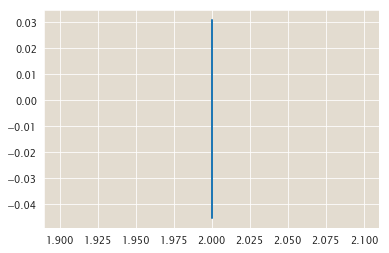

In [1981]:
# plt.plot(1/dfc_df, df_dfc)
# plt.plot(1/dfc_df_emp, df_dfc_emp)
plt.plot((1/dfc_df) - df_dfc_emp)


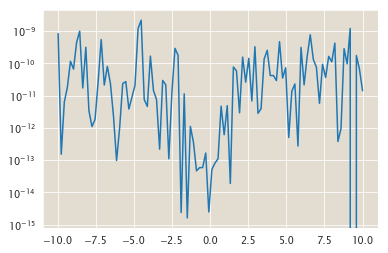

In [1999]:
dF = (np.exp(-bohr['median']) / (1 + np.exp(-bohr['median']))**2) - (_fc_mu - _fc_mu**2)


In [ ]:
plt.plot(fc_mu, np.abs(1/ (fc_mu**2 - fc_mu)))
plt.plot(fc_mu, np.abs(1/ (_fc_mu**2 - _fc_mu0)), '.')
# plt.plot(np.abs(1/ (fc_mu**2 - fc_mu)) - np.abs(1/ (_fc_mu**2 - _fc_mu)))
plt.yscale('log')

In [1927]:
corr

array([-21.05263158, -21.05263158, -21.05263158, -21.05263158,
       -21.05263158, -21.05263158, -21.05263158, -21.05263158,
       -21.05263158, -21.05263158, -21.05263158, -21.05263158,
       -21.05263158, -21.05263158, -21.05263158, -21.05263158,
       -21.05263158, -21.05263158, -21.05263158, -21.05263158,
       -21.05263158, -21.05263158, -21.05263158, -21.05263158,
       -21.05263158, -21.05263158, -21.05263158, -21.05263158,
       -21.05263158, -21.05263158, -21.05263158, -21.05263158,
       -21.05263158, -21.05263158, -21.05263158, -21.05263158,
       -21.05263158, -21.05263158, -21.05263158, -21.05263158,
       -21.05263158, -21.05263158, -21.05263158, -21.05263158,
       -21.05263158, -21.05263158, -21.05263158, -21.05263158,
       -21.05263158, -21.05263158, -21.05263158, -21.05263158,
       -21.05263158, -21.05263158, -21.05263158, -21.05263158,
       -21.05263158, -21.05263158, -21.05263158, -21.05263158,
       -21.05263158, -21.05263158, -21.05263158, -21.05